# Inferring iModulon activities for new data

Re-computing the complete set of iModulons can be computationally intensive for every new dataset. However, once a dataset reaches a critical size, you can use a pre-computed ``IcaData`` object to infer the iModulon activities of a new dataset. iModulon activities are relative measures; every dataset must have a reference condition to which all other samples are compared against.

To compute the new iModulon activities, first load the pre-computed ``IcaData`` object.

In [1]:
from pymodulon.data.example_data import load_ecoli_data
ica_data = load_ecoli_data()

Next, load your expression profiles. This should be normalized using whichever read mapping pipeline you use, as Transcripts per Million (TPM) or log-TPM.

In [15]:
from pymodulon.data.example_data import load_example_tpm
tpm = load_example_tpm()
tpm.head()

,Reference_1,Reference_2,Test_1,Test_2
b0002,60272.783229,68198.723226,121169.203039,145540.593264
b0003,33377.061960,37164.565132,91475.255777,133756.167521
b0004,39928.516390,45480.549892,34795.427264,48008.860171
b0005,552.411384,521.433922,225.360458,206.705418
b0006,1007.047765,988.893260,875.244163,881.364195


To convert TPM to log-TPM, a pseudo-count must be added to avoid taking the logarithm of zero.

In [17]:
log_tpm = np.log(tpm+1)
log_tpm.head()

,Reference_1,Reference_2,Test_1,Test_2
b0002,11.006653,11.130196,11.704951,11.888217
b0003,10.415654,10.523138,11.423835,11.803781
b0004,10.594871,10.725062,10.457270,10.779162
b0005,6.316102,6.258499,5.422129,5.336121
b0006,6.915771,6.897597,6.775645,6.782605


Next, make sure your dataset uses similar gene names as the target `IcaData` object.

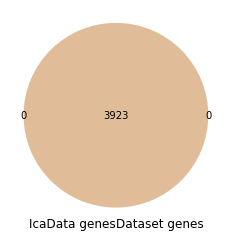

In [22]:
from matplotlib_venn import venn2
venn2((set(ica_data.gene_names),set(log_tpm.index)), set_labels=['IcaData genes','Dataset genes'])

Only genes shared between your ``IcaData`` object and the new expression profiles will be used to project your data. All other genes will be ignored.

Then, center your dataset on a reference condition, taking the average of replicates.

In [25]:
centered_log_tpm = log_tpm.sub(log_tpm[['Reference_1','Reference_2']].mean(axis=1),axis=0)
centered_log_tpm.head()

,Reference_1,Reference_2,Test_1,Test_2
b0002,-0.061772,0.061772,0.636527,0.819793
b0003,-0.053742,0.053742,0.954439,1.334385
b0004,-0.065095,0.065095,-0.202697,0.119195
b0005,0.028802,-0.028802,-0.865171,-0.951179
b0006,0.009087,-0.009087,-0.131039,-0.124079


Finally, use the ``pymodulon.util.infer_activities`` function to infer the relative iModulon activities of your dataset.

In [27]:
from pymodulon.util import infer_activities

In [28]:
activities = infer_activities(ica_data,centered_log_tpm)
activities.head()

,Reference_1,Reference_2,Test_1,Test_2
AllR/AraC/FucR,0.375525,-0.375525,2.258555,2.018295
ArcA-1,-0.429203,0.429203,-5.832628,-6.232075
ArcA-2,0.900395,-0.900395,1.986767,2.262015
ArgR,-0.291826,0.291826,-9.902345,-13.006574
AtoC,0.241034,-0.241034,1.592341,1.823258


All of the plotting functions in ``pymodulon.plotting`` can be used on your inferred activities once you add it to a new ``IcaData`` object. It is advisable to create a new ``sample_table`` with ``project`` and ``condition`` columns.

In [30]:
from pymodulon.core import IcaData

In [40]:
new_sample_table = pd.DataFrame([['new_data','reference']]*2+[['new_data','test']]*2,columns=['project','condition'],index=log_tpm.columns)
new_sample_table

,project,condition
Reference_1,new_data,reference
Reference_2,new_data,reference
Test_1,new_data,test
Test_2,new_data,test


In [41]:
new_data = IcaData(ica_data.M,
                   activities,
                   X = centered_log_tpm,
                   log_tpm = log_tpm,
                   gene_table = ica_data.gene_table,
                   sample_table = new_sample_table,
                   imodulon_table = ica_data.imodulon_table)

In [42]:
from pymodulon.plotting import *

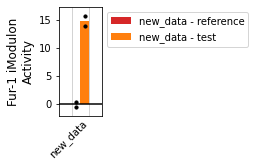

In [44]:
plot_activities(new_data,'Fur-1',highlight='new_data')